In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
import struct
import os

def read_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images = struct.unpack('>II', f.read(8))
        rows, cols = struct.unpack('>II', f.read(8))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    return images

def read_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Replace these paths with your actual file paths
train_images_path = 'Dataset/train-images-idx3-ubyte/train-images-idx3-ubyte'  # Update with your path
train_labels_path = 'Dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte'  # Update with your path
test_images_path = 't10k-images-idx3-ubyte'    # Update with your path
test_labels_path = 't10k-labels-idx1-ubyte'    # Update with your path

# Load data
train_images = read_mnist_images(train_images_path)
train_labels = read_mnist_labels(train_labels_path)

# Create DataFrames
# First for the features (images)
train_df = pd.DataFrame(train_images)
# Add the labels
train_df['label'] = train_labels


In [13]:
df=train_df.copy()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [14]:
data=df.values
np.random.shuffle(data)
num_samples=data.shape[0]
train_end = int(0.7 * num_samples)
val_end= int(0.85*num_samples)
train_data=data[:train_end]
val_data=data[train_end:val_end]
test_data=data[val_end:]

X_train=train_data[:,:-1]
y_train=train_data[:,-1]
X_val=val_data[:,:-1]
y_val=val_data[:,-1]
X_test=test_data[:,:-1]
y_test=test_data[:,-1]
X_train=X_train/255.0
X_val=X_val/255.0
X_test=X_test/255.0



Neural Layer Creation

In [29]:
class Layer_Dense:
    def __init__(self,n_inputs,n_neuron,L1_weight_regulaizer=0,L1_bias_regulaizer=0
                 ,L2_weight_regulaizer=0,L2_bias_regulaizer=0):
        self.weights=0.10*np.random.randn(n_inputs,n_neuron)
        self.bias=0.10*np.random.randn(1,n_neuron)
        self.weight_regulaizer_l1=L1_weight_regulaizer
        self.bias_regulaizer_l1=L1_bias_regulaizer
        self.weight_regulaizer_l2=L2_weight_regulaizer
        self.bias_regulaizer_l2=L2_bias_regulaizer
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.dot(inputs,self.weights)+self.bias
    def backward(self,dvalues):
        self.dweights=np.dot(self.inputs.T,dvalues)
        self.dbias=np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs=np.dot(dvalues,self.weights.T)

        if self.weight_regulaizer_l1>0:
            dl1=np.ones_like(self.weights)
            dl1[self.weights<0]=-1
            self.dweights +=self.weight_regulaizer_l1 * dl1
        if self.weight_regulaizer_l2>0:
            self.dweights+=2*self.weight_regulaizer_l2*self.weights
        if self.bias_regulaizer_l1>0:
            dl1=np.ones_like(self.bias)
            dl1[self.bias<0]= -1
            self.dbias +=self.bias_regulaizer_l1*dl1
        if self.bias_regulaizer_l2>0:
            self.dbias += 2*self.bias_regulaizer_l2 *self.bias
        self.dinputs=np.dot(dvalues,self.weights.T)


ReLU Activation

In [16]:
class Activation_RelU:
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.maximum(0,inputs)
    def backward(self,dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs<=0]=0

SoftMax Activation

In [17]:
class Activation_SoftMax:
    def forward(self,inputs):
        self.inputs=inputs
        exp_values=np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        probablities=exp_values/np.sum(exp_values,axis=1,keepdims=True)
        self.output=probablities

Loss Calculation

In [27]:
class Loss:
    def regulaization_loss(self,layer):
        regularization_loss=0

        if layer.weight_regulaizer_l1>0:
            regularization_loss+=layer.weight_regulaizer_l1*np.sum(np.abs(layer.weights))
        if layer.weight_regulaizer_l2>0:
            regularization_loss+=layer.weight_regulaizer_l2*np.sum(layer.weights*layer.weights)
        if layer.bias_regulaizer_l1>0:
            regularization_loss +=layer.bias_regulaizer_l1*np.sum(np.abs(layer.bias))
        if layer.bias_regulaizer_l2>0:
            regularization_loss+=layer.bias_regulaizer_l2*np.sum(layer.bias*layer.bias)
        return regularization_loss    

    def calculate(self,output,y):
        sample_losses=self.forward(output,y)
        data_loss=np.mean(sample_losses)
        return data_loss
class Loss_CategoricalCross_Entropy(Loss):
    def forward(self,y_pred,y_true):
        samples=len(y_pred)
        y_pred_clipped=np.clip(y_pred,1e-7,1-1e-7)
        if len(y_true.shape)==1:
            correct_confidence=y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape)==2:
            correct_confidence=np.sum(y_pred_clipped*y_true,axis=1)
        negative_log_likelihood=-np.log(correct_confidence)
        return negative_log_likelihood

Loss of Cross Entropy Activation of Softmax

In [19]:
class Activation_SoftMax_Loss_Catorgorical_Cross_Entropy():
    def __init__(self):
        self.activation=Activation_SoftMax()
        self.loss=Loss_CategoricalCross_Entropy()
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output=self.activation.output
        return self.loss.calculate(self.output,y_true)
    def backward(self,dvalues,y_true):
        samples=len(dvalues)
        if len(y_true.shape)==2:
            y_true=np.argmax(y_true,axis=1)
        self.dinputs=dvalues.copy()
        self.dinputs[range(samples),y_true] -=1
        self.dinputs=self.dinputs/samples
    

Dropout Layer

In [46]:
class Layer_Dropout:
    def __init__(self,rate):
        self.rate=rate
    def forward(self,inputs):
        self.inputs=inputs
        self.binary_mask=np.random.binomial(1,self.rate,size=inputs.shape)/self.rate
        self.output=inputs*self.binary_mask
    def backward(self,dvalues):
        self.dinputs=dvalues*self.binary_mask
        

Gradient descent Optimizer

In [20]:
class Optimizer_GD:
    def __init__(self,learning_rate=1):
        self.learning_rate=learning_rate
    def update_params(self,layer):
        layer.weights += -self.learning_rate*layer.dweights
        layer.bias += -self.learning_rate*layer.dbias


Adam Optimizer

In [21]:
class Optimizer_Adam:
    def __init__(self,learning_rate=0.001,decay=0,epsilion=1e-7,beta_1=0.9,beta_2=0.9999):
        self.learning_rate=learning_rate
        self.current_learning_rate=learning_rate
        self.decay=decay
        self.epsilion=epsilion
        self.beta_1=beta_1
        self.beta_2=beta_2
        self.iterations=0
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate=self.learning_rate*(1/(1+self.decay*self.iterations))
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache=np.zeros_like(layer.weights)
            layer.weight_momentum=np.zeros_like(layer.weights)
            layer.bias_cache=np.zeros_like(layer.bias)
            layer.bias_momentum=np.zeros_like(layer.bias)
        layer.weight_momentum=self.beta_1*layer.weight_momentum +(1-self.beta_1)*layer.dweights
        layer.bias_momentum=self.beta_1*layer.bias_momentum + (1-self.beta_1)*layer.dbias
        
        weight_momentum_corrected=layer.weight_momentum / (1-self.beta_1**(self.iterations+1))
        bias_momentum_corrected=layer.bias_momentum /(1-self.beta_1**(self.iterations+1))

        layer.weight_cache=self.beta_2*layer.weight_cache +(1-self.beta_2)*layer.dweights**2
        layer.bias_cache=self.beta_2*layer.bias_cache +(1-self.beta_2)*layer.dbias**2

        weight_cache_corrected=layer.weight_cache/(1-self.beta_2**(self.iterations+1))
        bias_cache_corrected=layer.bias_cache/(1-self.beta_2**(self.iterations+1))

        layer.weights += -self.current_learning_rate*weight_momentum_corrected \
                         /(np.sqrt(weight_cache_corrected + self.epsilion))
        layer.bias += -self.current_learning_rate*bias_momentum_corrected \
                     / (np.sqrt(bias_cache_corrected + self.epsilion))
    def post_update_params(self):
        self.iterations +=1

Training

In [60]:
dense1=Layer_Dense(784,128,L2_weight_regulaizer=5e-4,L2_bias_regulaizer=5e-4)
activation1=Activation_RelU()
dense2=Layer_Dense(128,10)
dropout1=Layer_Dropout(0.4)
train_accuracies=[]
val_accuracies=[]
train_loss=[]
val_losses=[]
epoch=75
loss_activation=Activation_SoftMax_Loss_Catorgorical_Cross_Entropy()
optimizer=Optimizer_Adam(learning_rate=0.05,decay=5e-5)
for epoch in range(epoch):
    dense1.forward(X_train)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss=loss_activation.forward(dense2.output,y_train)
    regularization_loss=loss_activation.loss.regulaization_loss(dense1)+\
                        loss_activation.loss.regulaization_loss(dense2)
    loss=data_loss+regularization_loss
    predictions=np.argmax(loss_activation.output,axis=1)
    accuracy=np.mean(predictions==y_train)
    train_accuracies.append(accuracy)
    train_loss.append(loss)

    if not epoch %100==0:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy :.3f}, ' +
              f'val_acc: {val_acc:.3f}'
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}'+
              f'reg_loss: {regularization_loss:.3f})'+
              f' lr: {optimizer.current_learning_rate}')
    loss_activation.backward(loss_activation.output,y_train)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    # Validation
    dense1.forward(X_val)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    val_loss = loss_activation.forward(dense2.output, y_val)
    
    val_predictions = np.argmax(loss_activation.output, axis=1)
    val_acc = np.mean(val_predictions == y_val)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

epoch: 1, acc: 0.198, val_acc: 0.212loss: 5.968 (data_loss: 5.482reg_loss: 0.486) lr: 0.05
epoch: 2, acc: 0.318, val_acc: 0.363loss: 4.047 (data_loss: 3.544reg_loss: 0.502) lr: 0.049997500124993745
epoch: 3, acc: 0.343, val_acc: 0.439loss: 3.076 (data_loss: 2.543reg_loss: 0.533) lr: 0.04999500049995001
epoch: 4, acc: 0.390, val_acc: 0.566loss: 2.433 (data_loss: 1.861reg_loss: 0.572) lr: 0.04999250112483127
epoch: 5, acc: 0.436, val_acc: 0.568loss: 2.204 (data_loss: 1.588reg_loss: 0.615) lr: 0.04999000199960008
epoch: 6, acc: 0.478, val_acc: 0.617loss: 2.089 (data_loss: 1.431reg_loss: 0.658) lr: 0.04998750312421894
epoch: 7, acc: 0.493, val_acc: 0.645loss: 2.078 (data_loss: 1.380reg_loss: 0.698) lr: 0.049985004498650405
epoch: 8, acc: 0.508, val_acc: 0.662loss: 2.066 (data_loss: 1.332reg_loss: 0.734) lr: 0.049982506122857
epoch: 9, acc: 0.530, val_acc: 0.695loss: 2.048 (data_loss: 1.283reg_loss: 0.765) lr: 0.04998000799680128
epoch: 10, acc: 0.541, val_acc: 0.707loss: 2.012 (data_loss: 

Validation Accuracy

In [68]:
dense1.forward(X_val)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss=loss_activation.forward(dense2.output,y_val)

predictions=np.argmax(loss_activation.output,axis=1)
accuracy=np.mean(predictions==y_val)
    
print(f'acc: {accuracy :.3f}, ' +  f'loss: {loss:.3f}')

acc: 0.932, loss: 0.235


Testing data

In [69]:
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss=loss_activation.forward(dense2.output,y_test)

predictions=np.argmax(loss_activation.output,axis=1)
accuracy=np.mean(predictions==y_test)
    
print(f'acc: {accuracy :.3f}, ' +  f'loss: {loss:.3f}')

acc: 0.929, loss: 0.234


Training & Validation Loss vs Epochs

Text(0.5, 1.0, 'Loss vs Epochs')

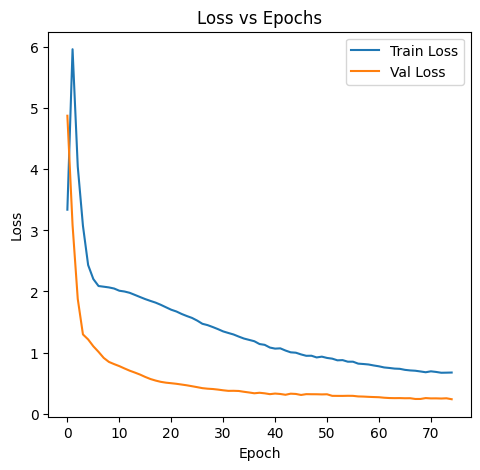

In [67]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')


Training and Validation accuracy vs Epochs


Text(0.5, 1.0, 'Accuracy vs Epochs')

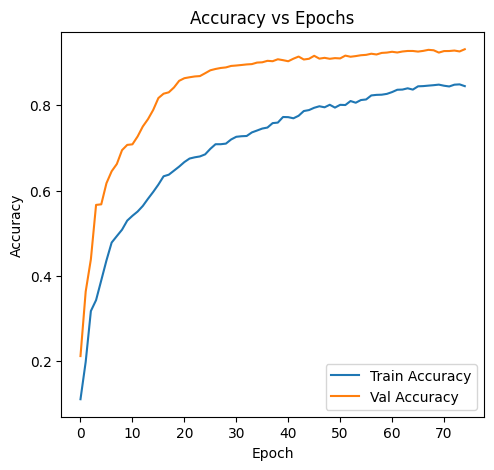

In [66]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
